In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

## open data

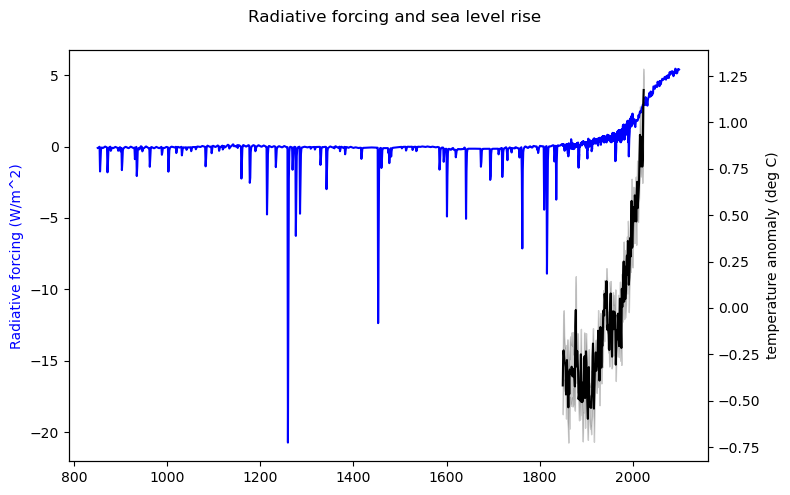

In [51]:
df_F = pd.read_csv('../data/final/forcing_all.csv', index_col=0)#[800:]
df_T = pd.read_csv('../data/final/temperature.csv', index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax2 = ax.twinx()
ax.plot(df_F.index, df_F['total'], color='blue', label='CO2')
ax.set_ylabel('Radiative forcing (W/m^2)', color='blue')

ax2.plot(df_T.index, df_T['Annual'], color='black', label='Sea level')
ax2.fill_between(df_T.index, df_T['Annual'] - df_T['Annual_uncertainty'], df_T['Annual'] + df_T['Annual_uncertainty'], color='black', alpha=0.2)
ax2.set_ylabel('temperature anomaly (deg C)', color='black')

fig.suptitle('Radiative forcing and sea level rise')
fig.tight_layout()
fig.subplots_adjust(top=0.9)

## Build model

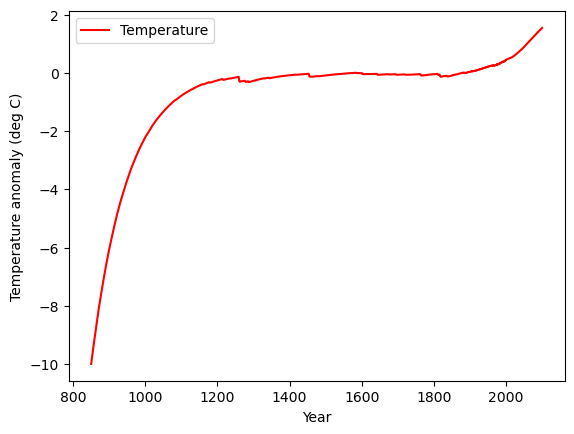

In [133]:
def get_T(F, T_0, tau1, a1, b1):
    # Calculate equilibrium temperature
    T_eq = a1 * F + b1

    # Initialize T
    T = np.zeros(len(F))
    T[0] = T_0
    for i in range(1, len(F)):
        # dT = T_eq[i-1] - T[i-1]
        T[i] = T[i-1] + ((T_eq[i-1] - T[i-1]) / tau1)

    # return np.cumsum(T)
    return T



T = get_T(df_F['total'].values, -10, 100, 0.5, .1)
plt.plot(df_F.index, T, color='red', label='Temperature')
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (deg C)')
plt.legend()

## Define prior, likelihood and probability

In [129]:

# Define the log prior function
def log_prior(theta):
    T_0, tau1, a1, b1 = theta
    cond1 = -50 < T_0 < 50
    cond2 = 1 < tau1 < 120
    cond3 = 0 < a1 < 50
    cond4 = 0 < b1 < 2

    if cond1 and cond2 and cond3 and cond4:
        return 0.0  # Uniform prior (log probability is zero within bounds)
    return -np.inf  # Log probability is -infinity outside bounds

# Define the log likelihood function
def log_likelihood(theta, F, obs, sigma):

    time_F = df_F.index
    time_obs = obs.index
    T_0, tau1, a1, b1 = theta

    T_model = get_T(F.values, T_0, tau1, a1, b1)

    # align times of F and S
    low = int(max(time_F[0], time_obs[0]))
    high = int(min(time_F[-1], time_obs[-1]))
    # print(low, high)

    T_model = T_model[low-time_F[0]:high-time_F[0]+1]

    # Compute the log likelihood assuming Gaussian errors
    return 0.5 * np.sum(((obs - T_model) / sigma)**2 + np.log(2 * np.pi * sigma**2))

# Define the full log probability function
def log_probability(theta, F, S_obs, sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, F, S_obs, sigma)

# try log likelihood
theta = [-20, 1.5, .5, 2]
log_likelihood(theta, df_F['total'], df_T['Annual'], df_T['Annual_uncertainty'])


42526.35096342739

## minimize

/Users/tonton/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/Users/tonton/anaconda3/envs/pymc_env/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 1458.6296776324352
        x: [-4.000e+00  4.200e+01  1.000e+00  3.000e-01]
      nit: 0
      jac: [ 0.000e+00 -1.901e+01 -3.834e+02  6.238e+03]
 hess_inv: [[1 0 0 0]
            [0 1 0 0]
            [0 0 1 0]
            [0 0 0 1]]
     nfev: 522
     njev: 102

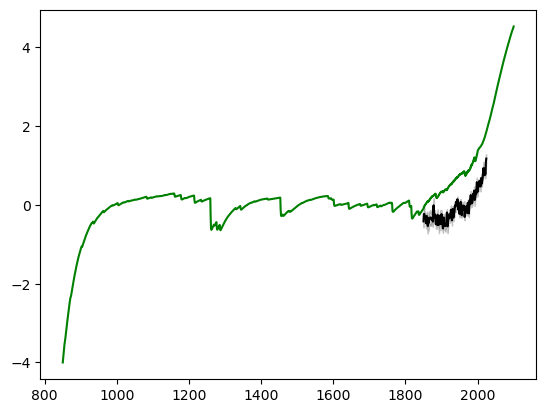

In [130]:
from scipy.optimize import minimize


# Find the maximum likelihood value

p0 = [-4, 42, 1, .3]
def objective(theta):
    return log_probability(theta, df_F['total'], df_T['Annual'], df_T['Annual_uncertainty'])

soln = minimize(objective, p0)



# plot solution
T = get_T(df_F['total'].values, *soln.x)

plt.plot(df_F.index, T, color='green', label='Temperature')
plt.plot(df_T.index, df_T['Annual'], color='black', label='Sea level')
plt.fill_between(df_T.index, df_T['Annual'] - df_T['Annual_uncertainty'], df_T['Annual'] + df_T['Annual_uncertainty'], color='black', alpha=0.2)
soln

## MCMC

Running burn-in...


100%|██████████| 500/500 [00:07<00:00, 63.95it/s]


Running production...


100%|██████████| 1500/1500 [00:19<00:00, 77.21it/s]


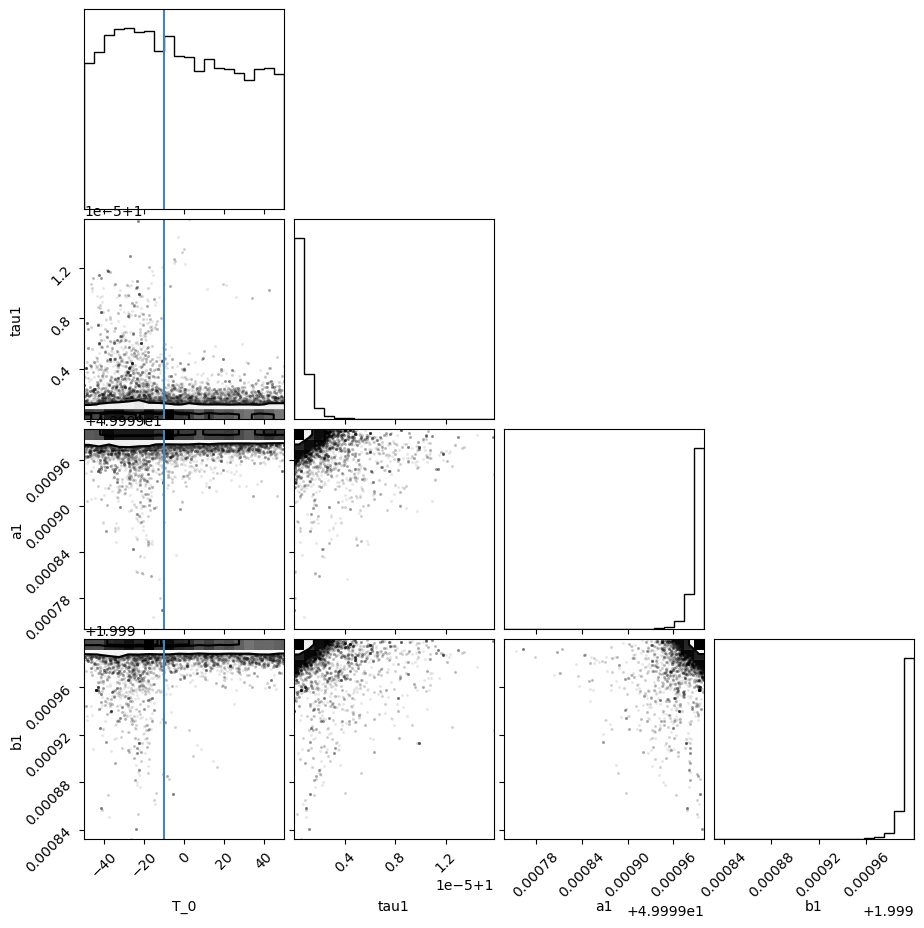

T_0 = -4.451 (+36.501, -30.112)
tau1 = 1.000 (+0.000, -0.000)
a1 = 50.000 (+0.000, -0.000)
b1 = 2.000 (+0.000, -0.000)


In [131]:
initial = [-10, 20, 3, 1]  # Initial guess for the parameters


# Set up the MCMC sampler
ndim = len(initial)  # Number of parameters
nwalkers = 32  # Number of MCMC walkers
# Initialize the walkers in a small Gaussian ball around the initial guess
pos = initial + 1e-4 * np.random.randn(nwalkers, ndim)

# Run MCMC using emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=( df_F['total'], df_T['Annual'], df_T['Annual_uncertainty']))

# Burn-in phase
print("Running burn-in...")
sampler.run_mcmc(pos, 500, progress=True)
sampler.reset()

# Production run
print("Running production...")
sampler.run_mcmc(None, 1500, progress=True)

# Extract the samples
samples = sampler.get_chain(flat=True)

# Plot posterior distributions
fig = corner.corner(samples, labels=["T_0", "tau1", "a1", "b1"],
                    truths=initial)
plt.show()

# Compute the mean and uncertainties of the parameters
from IPython.display import display, Math
import scipy.stats as stats

param_names = ["T_0", "tau1", "a1", "b1"]
for i in range(ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{0} = {1:.3f} (+{2:.3f}, -{3:.3f})".format(param_names[i], mcmc[1], q[1], q[0])
    print(txt)

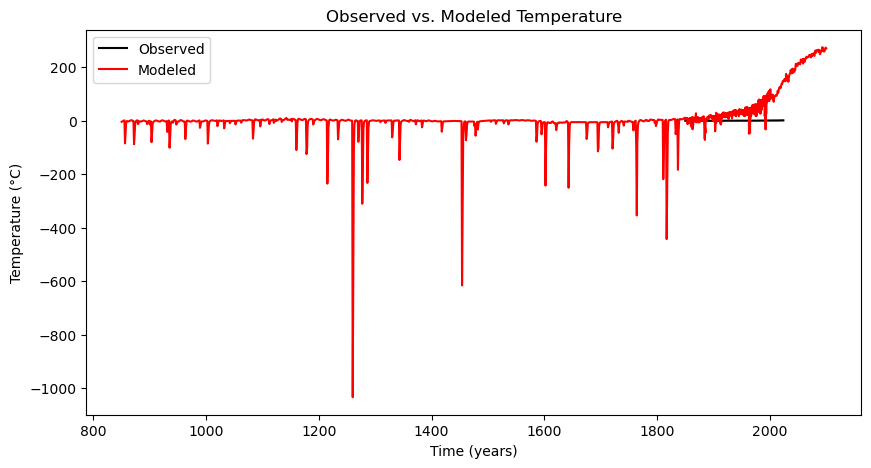

In [132]:
# Use the median parameters to compute the modeled sea level
best_params = np.median(samples, axis=0)


T_0_best, tau1_best, a1_best, b1_best = best_params

T_model_full = get_T(df_F['total'].values, T_0_best, tau1_best, a1_best, b1_best)

# Plot the observed vs. modeled temperature
plt.figure(figsize=(10, 5))
plt.plot(df_T.index, df_T['Annual'], color='black', label='Observed')
plt.fill_between(df_T.index, df_T['Annual'] - df_T['Annual_uncertainty'], df_T['Annual'] + df_T['Annual_uncertainty'], color='black', alpha=0.2)
plt.plot(df_F.index, T_model_full, color='red', label='Modeled')

plt.xlabel('Time (years)')
plt.ylabel('Temperature (°C)')
plt.title('Observed vs. Modeled Temperature')
plt.legend()
plt.show()